In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sc
import pandas as pd
import itertools as it
import collections
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def make_scatter(x, y, title = None, xlabel = None, ylabel = None, filename = None):
    '''
    This function generates scatter plot of a pair of vectors x and y, and save to file
    Inputs:
      x, y: data vectors
      title:    title of the plot
      xlabel:   label on x-axis
      ylabel:   label on y-axis
      filename: name of the image file (if given, save to file)
    Side effect:
      save an image file if filename is given
    '''
    
    import matplotlib
    matplotlib.use('agg')
    from matplotlib import pyplot as plt
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x, y)
    
    if(xlabel != None):
        ax.set_xlabel(xlabel)
    if(ylabel != None):
        ax.set_ylabel(ylabel)
    if(title != None):
        ax.set_title(title)
    if(filename != None):
        fig.savefig(filename)

LD file is computed with the following commands
```
[ytanigaw@sh-5-32 /share/PI/mrivas/ukbb/download]$ plink2 --make-bed --bpfile ./chr20impv1-pgen --memory 8000 --out ./chr20impv1
[ytanigaw@sh-5-32 /share/PI/mrivas/ukbb/download]$ # plink --bfile chr20impv1 --memory 8000 --ld-window 100 --ld-window-kb 10000 --r2 --out ./chr20impv1-10k 
```

```
[ytanigaw@sh-5-32 /share/PI/mrivas/ukbb/download]$ plink --bfile chr20impv1 --memory 8000 --ld-window 1000 --ld-window-kb 10000 --r2 --out ./chr20impv1-10m
```


In [22]:
ld_file = '/share/PI/mrivas/ukbb/download/chr20impv1-10m.ld'

In [23]:
!head $ld_file

 CHR_A         BP_A                               SNP_A  CHR_B         BP_B                               SNP_B           R2 
    20        60522                         rs150241001     20        61279                         rs189899941     0.702198 
    20        60522                         rs150241001     20        67641                          rs76107804            1 
    20        60522                         rs150241001     20        73719                         rs148228636      0.44411 
    20        60522                         rs150241001     20        98447                          rs76760245     0.326092 
    20        60828                         rs187713677     20        63257                         rs574916570     0.728223 
    20        60895                         rs556457573     20        62955                         rs553526603     0.473622 
    20        61044                         rs535668403     20        61947                                   .     0.

In [24]:
#ld_df = pd.read_csv(ld_file, delimiter='\s+', nrows=10)
ld_df = pd.read_csv(ld_file, delimiter='\s+')

In [25]:
ld_df['BP_diff'] = ld_df['BP_B'] - ld_df['BP_A']

In [26]:
ld_df.head()

,CHR_A,BP_A,SNP_A,CHR_B,BP_B,SNP_B,R2,BP_diff
0,20,60522,rs150241001,20,61279,rs189899941,0.702198,757
1,20,60522,rs150241001,20,67641,rs76107804,1.000000,7119
2,20,60522,rs150241001,20,73719,rs148228636,0.444110,13197
3,20,60522,rs150241001,20,98447,rs76760245,0.326092,37925
4,20,60828,rs187713677,20,63257,rs574916570,0.728223,2429


# data process
1. take pair of SNPs with >= R^2
1. For each left SNP, take the furtherest SNPs

In [27]:
LD_block_df = ld_df[ld_df['R2'] >= 0.2].groupby(by = ['BP_A']).agg({'BP_diff' : np.max, 'R2' : np.min})

In [28]:
LD_block_df.head()

,BP_diff,R2
BP_A,,
60522,37925,0.326092
60828,2429,0.728223
60895,2060,0.473622
61044,903,0.343703
61070,359,0.240020


In [29]:
LD_block_ndary = LD_block_df.as_matrix()

In [30]:
LD_block_ndary.shape

(765313, 2)

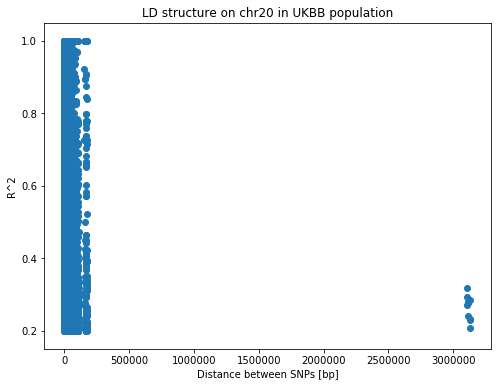

In [31]:
make_scatter(LD_block_ndary[:, 0], LD_block_ndary[:, 1],
             title = 'LD structure on chr20 in UKBB population', 
             xlabel = 'Distance between SNPs [bp]', 
             ylabel = 'R^2',
             filename = './LD_plot_UKBB.png')

In [37]:
max_dist = 500000

In [38]:
LD_block_ndary[LD_block_ndary[:, 0] <= max_dist, :].shape

(765303, 2)

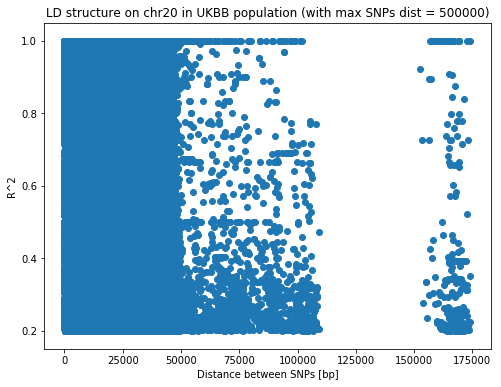

In [39]:
make_scatter(LD_block_ndary[LD_block_ndary[:, 0] <= max_dist, 0], 
             LD_block_ndary[LD_block_ndary[:, 0] <= max_dist, 1],
             title = 'LD structure on chr20 in UKBB population (with max SNPs dist = {})'.format(max_dist), 
             xlabel = 'Distance between SNPs [bp]', 
             ylabel = 'R^2',
             filename = './LD_plot_UKBB_{}.png'.format(max_dist))

# box plots for each axis

## y-axis

{'boxes': [<matplotlib.lines.Line2D at 0xa66a610>],
 'caps': [<matplotlib.lines.Line2D at 0xa66d510>,
 'fliers': [<matplotlib.lines.Line2D at 0xa672810>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xa6721d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0xa66a790>,
  <matplotlib.lines.Line2D at 0xa66ae90>]}

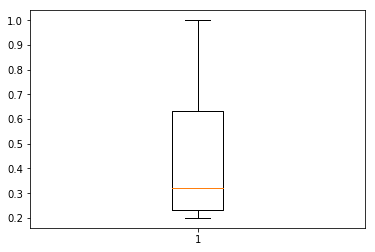

In [40]:
plt.boxplot(LD_block_ndary[:, 1])

## x-axis

{'boxes': [<matplotlib.lines.Line2D at 0x66bc9d0>],
 'caps': [<matplotlib.lines.Line2D at 0x311ce8d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x311d1bd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x311d1590>],
 'whiskers': [<matplotlib.lines.Line2D at 0x66bcb50>,
  <matplotlib.lines.Line2D at 0x311ce290>]}

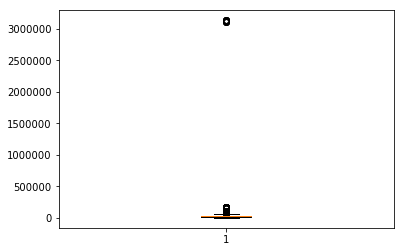

In [41]:
plt.boxplot(LD_block_ndary[:, 0])

{'boxes': [<matplotlib.lines.Line2D at 0x31d74c50>],
 'caps': [<matplotlib.lines.Line2D at 0x31d7c690>,
 'fliers': [<matplotlib.lines.Line2D at 0x31d93110>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xa63de90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x31d74610>,
  <matplotlib.lines.Line2D at 0x31d7c550>]}

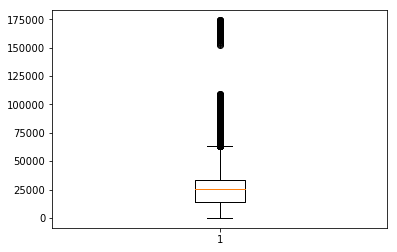

In [42]:
plt.boxplot(LD_block_ndary[LD_block_ndary[:, 0] <= max_dist, 0])

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x31f6b1d0>],
 'caps': [<matplotlib.lines.Line2D at 0x43b5cd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x31f81990>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x43bf2d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x31f6bed0>,
  <matplotlib.lines.Line2D at 0x43b54d0>]}

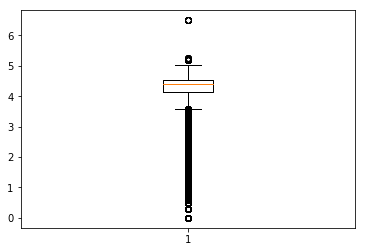

In [43]:
plt.boxplot(np.log(LD_block_ndary[:, 0]) / np.log(10))

/home/ytanigaw/.conda/envs/pgenlib/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


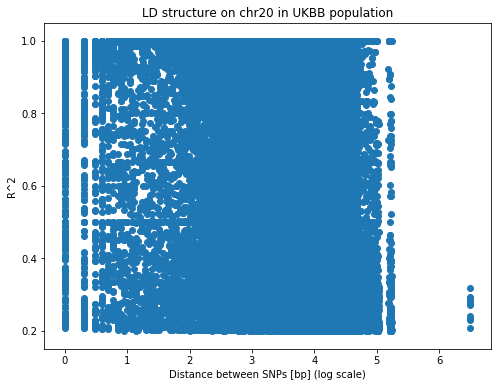

In [44]:
make_scatter(np.log(LD_block_ndary[:, 0]) / np.log(10), LD_block_ndary[:, 1],
             title = 'LD structure on chr20 in UKBB population', 
             xlabel = 'Distance between SNPs [bp] (log scale)', 
             ylabel = 'R^2',
             filename = './LD_plot_UKBB_log.png')